<a href="https://colab.research.google.com/github/MeghnaDixit38/BTP/blob/main/1st_order_einstein_eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch 
import torch.nn as nn
import torch.autograd as ag

In [2]:
pi = np.pi
from torch.utils.data import Dataset, DataLoader

Solving the PDE: \\
$$-u'(x) = f(x)$$
Given: $$u (x \rightarrow \infty) = 0$$


eq: \\
$$e^{-\lambda} \left(\frac{\nu^{'}}{r} + \frac{1}{r^2} \right) - \frac{1}{r^2} = 0$$
$$e^{-\lambda} \left(\frac{\lambda^{'}}{r} - \frac{1}{r^2} \right) - \frac{1}{r^2} = 0$$

In [14]:
def exact(xt):
  u = 1-1/xt
  return u

def f(u , xt):
    return (1 - u)/xt

Exact: 
$$ e^{\nu} = 1 + \frac{const}{r} $$

In [4]:
# $$ u(x) = \cos(2\pi x)$$
# $$ f(x) = 4\pi^2 \cos(2\pi x) $$

x0 = 0.0
xf = 1.0
dx = 0.001
nx = int((xf - x0)/dx)

u0 = 2*pi
xs = np.linspace(x0, xf, (nx + 1))

In [5]:
class data(Dataset):
  def __init__(self, x):
    self.ts = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    xs = self.x[idx]
    return xs

def tensor(x):
    return torch.tensor(x, dtype=torch.float32)

In [6]:
class DNN(nn.Module):
    def __init__(self, dim_in=1, dim_out=1,
                 n_layers=2, n_neurons=10, activation=nn.ReLU()):
        super(DNN, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation

        layers = [nn.Linear(dim_in, n_neurons), activation]
        for i in range(n_layers - 2):
            layers.extend([nn.Linear(n_neurons, n_neurons), activation])
        layers.extend([nn.Linear(n_neurons, dim_out)])
        self.layers = nn.Sequential(*layers)

    def forward(self, xt):
        return self.layers(xt)

def _D1(u, x, idx_u=0):
    Du = ag.grad(
        u[:, idx_u], x, torch.ones_like(u[:, idx_u]),
        create_graph=True
    )[0]
    return Du

def _D2(u, x, idx_u=0, idx_x=0):
    Du = ag.grad(
        u[:, idx_u], x, torch.ones_like(u[:, idx_u]),
        create_graph=True
    )[0]
    grad_out = torch.zeros_like(Du)
    grad_out[:, idx_x] = 1.0
    D2u = ag.grad(Du, x, grad_out, create_graph=True)[0]
    return D2u

class PhysicsLoss:
    def __init__(self, model):
        self.model = model

    def __call__(self, xs):
        '''
        This function needs to be implemented for each problem.
        '''
        raise NotImplementedError()

In [7]:
class UnitInterval(Dataset):
    def __init__(self, n_interior=100000, left = 1.0, right = 10000.0):
        h = (right-left)/n_interior
        self.n_interior = n_interior
        xs = np.linspace(left + h/5, right - h/5, n_interior)
        self.xs = xs.reshape((n_interior, 1))
        self.xbs_l = np.array([left]).reshape((1, 1))
        self.xbs_r = np.array([right]).reshape((1, 1))

    def __len__(self):
        return self.n_interior

    def __getitem__(self, idx):
        return self.xs[idx]


class Residual(PhysicsLoss):
    def __init__(self, model, data, fn, bdy_wt_l =1.0, bdy_wt_r =1.0):
      super().__init__(model)

      self.model = model
      self.data = data
      self.fn = fn
      self.bdy_wt_l = bdy_wt_l
      self.bdy_wt_r = bdy_wt_r

    def _squared_residual(self, x, u , ux):
      return (ux - self.fn(u , x))**2

    def _interior_loss(self, xs):
      u = self.model(xs)
      D1u = _D1(u, xs)
      D2u = _D2(u, xs)
      loss_int = torch.mean(self._squared_residual(xs, u , D1u))
      return loss_int


    def _boundary_loss(self, xs, bc = 1.0):
      u = self.model(xs)
      loss_bdy = torch.sum((u-bc)**2)
      return loss_bdy

    def __call__(self, xs):
      loss = self._interior_loss(xs)

      if self.bdy_wt_r > 1e-6:
          loss +=  self.bdy_wt_r*self._boundary_loss(tensor(self.data.xbs_r))
      return loss

def L2_loss(model,data):
      u = model(tensor(data))
      loss = torch.mean((u - exact(tensor(data)))**2)
      return loss

def _epoch_train(model, loss_fn, optimizer, batch):
    train_loss = 0.0
    L2 = 0.0
    dl = DataLoader(loss_fn.data, batch_size=batch, shuffle=True)

    for xs in dl:
        xs = xs.float().requires_grad_(True)
        optimizer.zero_grad()
        loss = loss_fn(xs)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_l2 = L2_loss(model, xs)
        train_loss += loss.item()
        L2 += loss_l2
    L2 /= len(dl)
    train_loss /= len(dl)
    return train_loss, L2


def train(model, loss_fn, optimizer, batch=32, n_epochs=1000, n_skip=100):
    losses = []
    L2 = []
    data = loss_fn.data
    for epoch in range(n_epochs):
        loss = _epoch_train(model, loss_fn, optimizer, batch)
        train_loss = loss[0]
        losses.append(train_loss)
        loss_2 = loss[1]
        loss_2 = loss_2.detach().numpy()
        L2.append(loss_2)

        if n_skip > 0:
            if epoch % n_skip == 0:
                print(f'Epoch {epoch}/{n_epochs}: Loss = {train_loss}, L2 Loss = {loss_2}')
    return np.array(losses), np.array(L2)



def plot_solution(model, data):
  us = model(tensor(data.xs))
  us = us.squeeze().detach().cpu().numpy()
  xs = data.xs.reshape(data.xs.size)
  us_exact = exact(xs)
  plt.plot(xs, us_exact, 'k-', lw=5, label='Exact')
  plt.plot(xs, us, 'r-', lw=2, label='DNN')
  # plt.xlim(0,1)
  plt.xlabel('x')
  plt.ylabel('$e^u$')
  plt.legend()
  plt.show()

def plot_soln(model, data):
  us = model(tensor(data.xs))
  us = us.squeeze().detach().cpu().numpy()
  xs = data.xs.reshape(data.xs.size)
  us_exact = exact(xs)
  plt.plot(1-1/xs, us_exact, 'k-', lw=5, label='Exact')
  plt.plot(1-1/xs, us, 'r-', lw=2, label='DNN')
  
  plt.xlabel('1-1/x')
  plt.ylabel('$e^u$')
  plt.legend()
  plt.show()

In [8]:
n_interior = 1000
train_data = UnitInterval(n_interior)

dnn = DNN(dim_in=1, dim_out=1, n_layers=3, n_neurons=10,
              activation=torch.nn.Tanh())

bdy_wt = 10.0
loss_fn = Residual(dnn, train_data, f)
lr = 1e-3
optimizer = torch.optim.SGD(dnn.parameters(), lr=lr)

batch = 200
epochs = 3000
n_skip = 500
loss = train(dnn, loss_fn, optimizer, batch=batch, n_epochs=epochs, n_skip=n_skip)
losses = loss[0]
L2 = loss[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch 0/3000: Loss = 0.3578436613082886, L2 Loss = 0.34723201394081116
Epoch 500/3000: Loss = 2.3775137915418853e-07, L2 Loss = 6.41215592622757e-06
Epoch 1000/3000: Loss = 2.3710089759043652e-07, L2 Loss = 6.413437404262368e-06
Epoch 1500/3000: Loss = 2.364505334889744e-07, L2 Loss = 6.414452855096897e-06
Epoch 2000/3000: Loss = 2.3580203179357494e-07, L2 Loss = 6.4155806285270955e-06
Epoch 2500/3000: Loss = 2.3515420838615687e-07, L2 Loss = 6.4166260926867835e-06


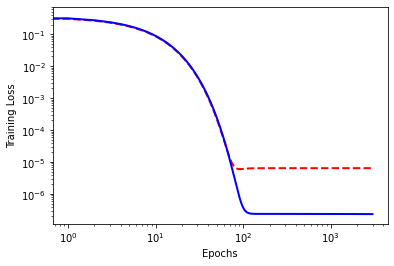

In [13]:
n_epochs = np.arange(epochs)
plt.loglog(n_epochs, L2, 'r--', linewidth=2)
plt.loglog(n_epochs, losses, 'b-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

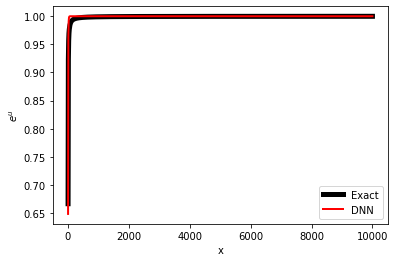

In [10]:
plot_solution(dnn, train_data)

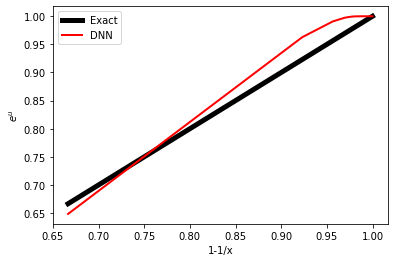

In [11]:
plot_soln(dnn, train_data)

In [12]:
n_test = 111
test_data = UnitInterval(n_test)
loss_test = Residual(dnn, test_data, f, bdy_wt=0.0)
test_loss = loss_test(tensor(loss_test.data.xs))
plot_solution(dnn, test_data)
# plot_solution 

TypeError: ignored